# ***Project_4.  Решение комплексной бизнес-задачи. Крапеницкая Е.***


## Цель проекта:

Подготовить данные для рекомендательной системы к курсам для онлайн-школы "MasterMind"

## Задача проекта: 

Создать таблицу с рекомендациями, благодаря которой можно будет предлагать клиентам интересные им курсы и тем самым повышать средний чек.

## Конкретные шаги(формализованные задачи):

1. Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.

2. Обработать данные средствами Python.

3. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт.

## 1. Подготовка данных с помощью SQL.

Нам даны 2 таблицы:

Таблица carts — данные о пользовательских корзинах.  
Promo Code ID — ID промокода, если он есть.  
Purchased At — дата оплаты.  
User ID — ID пользователя.  
Created At — дата создания корзины.  
Updated At — дата последнего обновления информации.  
ID — идентификатор корзины.  
State — состояние оплаты.  

Таблица cart items — данные о курсах, которые пользователи добавили в корзину.  
Created At — дата создания события.  
Resource Type — тип продукта.  
Resource ID — ID курса.  
Cart ID — идентификатор корзины.  
Updated At — дата последнего обновления информации.  
ID — идентификатор операции.  

Необходимые таблицы находятся в схеме final.

Из этих данных нам нужно составить таблицу с данными по продажам курсов в разрезе пользователей (купивших более одного курса). 

Сделаем это с помощью SQL-запроса.


with cnt_courses as  /*создаем СТЕ с количеством пройденных курсов, сгруппированных по пользователям(так как для создания рекомендательной системы нас интересуют пользователи, купившие более одного курса)*/  
(  
select  
user_id,  
count(distinct resource_id) count_courses  /*выбираем из таблиц пользователей и количества уникальных курсов, купленных ими*/  
from   
final.carts c   
join final.cart_items i on c.id = i.cart_id  /*соединяем таблицы*/  
where state = 'successful' and resource_type = 'Course'  */фильтруем таблицу по успешным оплатам и по типу продукта "курс"*/  
group by 1   /*группируем количество курсов по пользователям*/  
having count(distinct resource_id) > 1  /*ставим фильтр, чтобы оставить только пользователей, купивших более одного курса*/  
)  
select  /*здесь соединяем таблицу, получившуюся в СТЕ, с таблицей с данными о курсах, чтобы получить итоговую таблицу с пользователями, купившими более одного курса и id этих курсов*/  
distinct cc.user_id,  
resource_id  
from   
cnt_courses cc  
join final.carts c on cc.user_id = c.user_id  
join final.cart_items i on c.id = i.cart_id  
where state = 'successful' and resource_type = 'Course'  
order by 1  

У нас получилась таблица с двуми столбцами - id пользователей и id курсов, купленных этими пользователями. В таблице оставлены только пользователи, купившие более одного курса.  
Сохраним эту таблицу в формате CSV-файла, чтобы продолжить с ней работать средствами Python.

## 2. Обработка данных средствами Python.

Теперь нам нужно данные, полученные на предыдущем этапе, видоизменить так, чтобы на выходе получилась таблица с тремя столбцами:  
- Курс - целевой курс, к которому даются рекомендации.  
- Рекомендация №1 - первая рекомендация к целевому курсу.  
- Рекомендация №2 - вторая рекомендация к целевому курсу.

Рекомендации мы будем давать по принципу частоты покупок рекомендуемых курсов с целевым курсом. Рекомендация №1 - самый частопокупаемый курс с целевым курсом, Рекомендация №2 - второй по частоте покупок с целевым курсом. Курсы с низкой покупаемостью(ниже порога, который мы установим) мы предлагать не будем. Заменим их самыми популярными курсами. Естественно, нужно составить таблицу так, чтобы в одной строке курсы не повторялись.


План работы:  
- импортируем библиотеки и прочитаем данные.  
- создадим все возможные пары курсов, которые пользователи покупали вместе.  
- подсчитаем, сколько раз каждая пара курсов встречается в данных, чем чаще пара покупалась вместе, тем выше она ранжируется.  
- установим порог популярности, который будет определять, какие курсы считаются достаточно популярными для рекомендации.  
- для каждого курса мы выберем курсы для рекомендации №1 и №2, основываясь на том, как часто они покупались вместе с исходным курсом, при этом исключая сам исходный курс из списка возможных рекомендаций:  
Рекомендация №1 — это курс, который чаще всего покупался вместе с целевым курсом и превышает порог популярности.    
Рекомендация №2 — это второй по частоте курс, если он также превышает порог популярности. Если нет второго курса, превышающего порог, то выбирается следующий по популярности курс из всех курсов, который не является целевым.  
- если не будет достаточно популярных курсов для рекомендации, мы выберем самые популярные курсы из всех данных, исключая целевой курс, чтобы обеспечить уникальность рекомендаций.  
- сохраним нашу работу в формате Jupiter notebook а также итоговую таблицу в формате CSV.


In [1]:
# Импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Читаем файл, полученный на предыдущем этапе, смотрим, что получилось

df = pd.read_csv('data/courses_per_users.csv')
df.head()


,user_id,resource_id
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125


In [3]:
# Смотрим, нет ли в наших данных пропусков

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34074 entries, 0 to 34073
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      34074 non-null  int64
 1   resource_id  34074 non-null  int64
dtypes: int64(2)
memory usage: 532.5 KB


In [4]:
# Преобразование данных в формат, где строки - это пользователи, а значения - списки купленных курсов

courses_per_user = df.groupby('user_id')['resource_id'].apply(list).reset_index()
courses_per_user.head()


,user_id,resource_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"


In [5]:
 # Функция для создания всех возможных пар курсов для одного пользователя

def create_course_pairs(courses):
    pairs = []
    for i in range(len(courses)):
        for j in range(i + 1, len(courses)):
            pairs.append((courses[i], courses[j]))
    return pairs

In [6]:
# Применяем функцию к каждому пользователю

courses_per_user['course_pairs'] = courses_per_user['resource_id'].apply(create_course_pairs)
courses_per_user.head()

,user_id,resource_id,course_pairs
0,51,"[516, 1099]","[(516, 1099)]"
1,6117,"[356, 357, 1125]","[(356, 357), (356, 1125), (357, 1125)]"
2,10275,"[553, 1147]","[(553, 1147)]"
3,10457,"[361, 1138]","[(361, 1138)]"
4,17166,"[356, 357]","[(356, 357)]"


In [7]:
# Выравниваем пары, чтобы получить один столбец пар

all_pairs = courses_per_user['course_pairs'].explode().dropna()
all_pairs.head()

0    (516, 1099)
1     (356, 357)
1    (356, 1125)
1    (357, 1125)
2    (553, 1147)
Name: course_pairs, dtype: object

In [8]:
# Считаем частоту пар
pair_counts = all_pairs.value_counts().reset_index()
pair_counts.columns = ['pair', 'count']
pair_counts.head()

,pair,count
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290


In [9]:
# Разделяем пары на отдельные курсы для более удобного ранжирования
pair_counts[['course1', 'course2']] = pd.DataFrame(pair_counts['pair'].tolist(), index=pair_counts.index)
pair_counts.head()

,pair,count,course1,course2
0,"(551, 566)",797,551,566
1,"(515, 551)",417,515,551
2,"(489, 551)",311,489,551
3,"(523, 551)",304,523,551
4,"(566, 794)",290,566,794


Теперь нам нужно определить минимальную границу популярности. 

Сначала посмотрим распределение частоты количества покупок.

In [10]:
# Смотрим распределение частоты покупок по курсам.

course_purchases = df['resource_id'].value_counts()
display(course_purchases)


resource_id
551     2935
566     2342
515     1311
489     1125
490     1084
        ... 
1182       3
902        3
1199       2
1201       2
1200       2
Name: count, Length: 126, dtype: int64

По этой таблице сложно что-то понять, мы видим, что 2 самых популярных курса покупались 2935 и 2342 раза.

Для лучшего понимания построим график распределения популярности курсов, где по оси Х будет количество покупок, а по оси Y - частота покупок курсов.

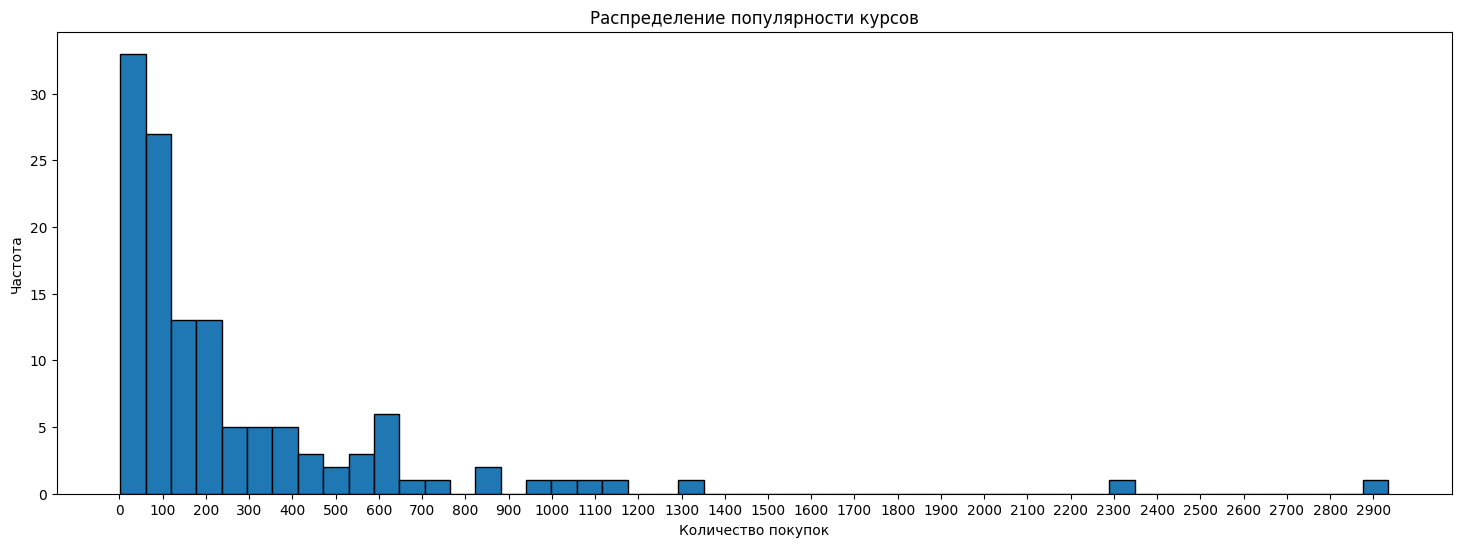

In [11]:
# Строим график

plt.figure(figsize=(18, 6))  
plt.hist(course_purchases, bins=50, edgecolor='black')
plt.title('Распределение популярности курсов')
plt.xlabel('Количество покупок')
plt.ylabel('Частота')
max_purchases = course_purchases.max()
xticks = np.arange(0, max_purchases, 100) # Для лучшего восприятия сделаем побольше отметок на оси Х
plt.xticks(xticks)

plt.show()

На графике видно, что два самых популярных курса выбиваются из общей картины, намного опережая остальные по числу покупок, но они являются исключением, чаще всего в данных встречается небольшое количество покупок(примерно до 50).  
Основная часть покупок распределена в интервале до 650 раз. В связи с этим стоит взять небольшую минимальную границу, чтобы не отсечь много курсов.  
Возьмем для этой цели 5й процентиль данных. Мы не будем рекомендовать 5% самых непопулярных курсов.

In [12]:
# Определяем минимальную границу для популярности

sorted_purchases = course_purchases.sort_values()
MIN_POPULARITY_THRESHOLD = sorted_purchases.iloc[int(len(sorted_purchases) * 0.05)]
print(MIN_POPULARITY_THRESHOLD)

3


5% для наших данных - это 3 покупки. Мы не будем рекомендовать курсы, купленные 3 раза и меньше. 

Создадим функцию, которая на основе нашего датафрейма pair_counts сделает нужную нам таблицу.

In [13]:
# Вспомним, как он выглядит

pair_counts.head()


,pair,count,course1,course2
0,"(551, 566)",797,551,566
1,"(515, 551)",417,515,551
2,"(489, 551)",311,489,551
3,"(523, 551)",304,523,551
4,"(566, 794)",290,566,794


In [14]:
# Функция для выбора рекомендации
def get_recommendation(course, df, position):
    # Находим все пары, где текущий курс является course1
    filtered = df[df['course1'] == course]
    
    # Фильтруем пары, оставляя только те, где количество совместных покупок с курсом превышает порог популярности.
    # Затем сортируем по убыванию частоты покупок пары.
    recommendations = filtered[filtered['count'] >= MIN_POPULARITY_THRESHOLD].sort_values('count', ascending=False)
    
    # Убираем целевой курс из возможных рекомендаций. 
    recommendations = recommendations[recommendations['course2'] != course]
    
    # Если после всех фильтров у нас есть достаточно курсов для рекомендации в заданной позиции (position),
    if len(recommendations) >= position:
        # Возвращаем курс из столбца 'course2' на позиции position-1
        return recommendations.iloc[position - 1]['course2']
    else:
        # Если нет достаточно популярных курсов для рекомендации, мы переходим к резервному плану:
        
        # Сначала получаем все уникальные курсы из 'course2'
        all_courses = df['course2'].unique()
        
        # Затем мы находим самые популярные курсы из всех, исключая текущий курс.
        # Суммируем количество покупок для каждого курса, сортируем по убыванию.
        popular_courses = df[df['course2'].isin(all_courses[all_courses != course])].groupby('course2')['count'].sum().sort_values(ascending=False)
        
        if not popular_courses.empty:
            # Если есть популярные курсы, возвращаем курс с индексом position-1 или первый курс, если position больше, чем количество курсов
            return popular_courses.index[position - 1] if position <= len(popular_courses) else popular_courses.index[0]
        else:
            # Если нет популярных курсов из всех, просто выбираем первый доступный курс, который не является целевым
            return [c for c in all_courses if c != course][0]

## 3. Наконец, сформируем итоговую таблицу.

In [15]:
 # Создаем список для хранения данных перед созданием DataFrame
recommendation_data = []

# Заполняем список
for course in pair_counts['course1'].unique():
    # Убеждаемся, что для каждого курса рекомендации разные
    rec1 = get_recommendation(course, pair_counts, 1)
    rec2 = get_recommendation(course, pair_counts, 2)
    while rec1 == rec2:
        rec2 = get_recommendation(course, pair_counts, 3)  # Используем следующую по популярности рекомендацию
    recommendation_data.append({
        'Курс': course,
        'Рекомендация №1': rec1,
        'Рекомендация №2': rec2
    })

# Создаем DataFrame из списка
recommendations = pd.DataFrame(recommendation_data)

recommendations.head()

,Курс,Рекомендация №1,Рекомендация №2
0,551,566,552
1,515,551,523
2,489,551,515
3,523,551,552
4,566,794,764


In [16]:
recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Курс             117 non-null    int64
 1   Рекомендация №1  117 non-null    int64
 2   Рекомендация №2  117 non-null    int64
dtypes: int64(3)
memory usage: 2.9 KB


Мы видим, что в нашей таблице 117 строк. Это равно количеству курсов.

Мы получили нужную нам таблицу, которая станет основой рекомендационной системы. В этой таблице собраны 117 курсов и по 2 рекомендации к каждому из них.

Теперь сохраним нашу таблицу в формате CSV для более удобного использования в дальнейшем.

In [17]:
recommendations.to_csv('recommendations.csv', index=False, encoding='utf-8')